<a href="https://colab.research.google.com/github/katygz/News-Recommendation-System-Based-on-User-History-Browsing-Clicks/blob/main/Model_by_Katy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
Based on news recommendations in a news app, the goal is to **predict the user's future click behavior based on the historical browsing and clicking data, specifically predicting the news article of the user's last click**.

## Data Overview
The user interaction data involves 300,000 users, nearly 3 million clicks, and over 360,000 different news articles, with each article having a corresponding embedding vector representation.

From this, we extract the click logs of 200,000 users as the training set, 50,000 users as Test Set A, and 50,000 users as Test Set B.

# Data Tables

- **train_click_log.csv**: Training set user click logs
- **testA_click_log.csv**: Test Set A user click logs
- **articles.csv**: News article information
- **articles_emb.csv**: News article embedding vector representations

|        **Field**        |         **Description**          |
| :---------------------: | :------------------------------: |
|         user_id         |             User ID              |
|    click_article_id     |         Clicked Article ID        |
|     click_timestamp     |        Click Timestamp           |
|    click_environment    |        Click Environment         |
|    click_deviceGroup    |         Click Device Group       |
|        click_os         |          Click Operating System  |
|      click_country      |           Click Country          |
|      click_region       |           Click Region           |
|   click_referrer_type   |         Click Referrer Type      |
|       article_id        |  Article ID, matches click_article_id |
|       category_id       |       Article Category ID        |
|      created_at_ts      |       Article Creation Timestamp |
|       words_count       |          Word Count              |
| emb_1, emb_2, ..., emb_249 |   Article Embedding Vector Representation |

## Evaluation Methodology
The final submission format requires recommending **five articles for each user**, sorted in descending order based on click probability.

Since each user has only one actual last-clicked article, we evaluate whether the correct article is among the five recommendations.

For example, for user1, the submission might look like:
> user1, article1, article2, article3, article4, article5

The scoring formula is as follows:
$$
score(user) = \sum_{k=1}^5 \frac{s(user, k)}{k}
$$

- If `article1` is the correct article, i.e., the actual clicked article, then \( s(user1, 1) = 1 \) and \( s(user1, 2-5) = 0 \).  
- If `article2` is the correct article, then \( s(user, 2) = \frac{1}{2} \) and \( s(user, 1, 3, 4, 5) = 0 \).  
The score reflects the **inverse rank** of the correct prediction—hits at higher ranks yield higher scores. If there is no hit, \( score(user1) = 0 \).

## Project Understanding
From the project overview, the objective is clear: **predict the last-clicked news article based on the user’s historical data**. This problem differs from traditional structured data projects in two ways:

1. **Objective**: The goal is to recommend news articles, not predict a number or category, as in typical classification or regression problems.
2. **Data Structure**: Unlike structured data with features and labels, we are working with click logs derived from real-world user behavior.

Thus, the problem needs to be transformed into a **supervised learning problem (features + labels)** to leverage ML and DL models for prediction.

Key questions to address:
- **How can this be transformed into a supervised learning problem?**
- **What type of supervised learning problem should it become?**
- **What features can we leverage?**
- **What models should we consider?**
- **How can we efficiently handle the scale of recommendations for thousands of articles and users?**

These questions will shape the problem-solving process. For example, can we treat this as a **multi-class classification problem** (predicting 1 out of 360,000 classes)? This is challenging due to the large number of classes, so we need an alternative approach.

Since we aim to predict the last-clicked article, **if we can estimate the click probability for each article** given a user's history, the problem becomes manageable. The article with the highest probability is the predicted last-clicked article. This reformulates the task into a **click-through rate (CTR) prediction problem**, which is well-suited to supervised learning techniques like logistic regression.

With this in mind, the solution involves building a **classification model** to predict the click probability for a user-article pair. This leads to several sub-questions:
- **How do we convert the problem into a supervised learning format?**
- **How do we prepare the training and test datasets?**
- **What features can be used?**
- **What models should we explore?**
- **How do we handle the massive number of articles and users?**
- **What strategies can we use for prediction and recommendation?**

## Multi-Channel Recall

A **multi-channel recall** strategy involves using multiple strategies, features, or simple models to generate candidate sets from different perspectives. These sets are merged for further ranking. This approach balances **computation speed** and **recall rate**. Simple strategies ensure fast recall, while diverse strategies maintain high recall, preserving ranking performance.

The figure below illustrates the concept of multi-channel recall. Since the strategies operate independently, they can be executed concurrently using multi-threading for improved efficiency.




In [1]:
!pip install -q tensorflow==2.8.0
!pip install -q faiss-gpu
!pip install -q deepctr
!pip install -q deepmatch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 30.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.23.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.8.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5

---

1. **aiss-cpu (Faiss):**  
   - **Features:** Faiss is a library designed for efficient similarity search and dense vector clustering. It offers a range of fast similarity search algorithms, especially useful for large-scale nearest neighbor search tasks.  
   - **Advantages:** In CPU environments, Faiss provides highly efficient vector similarity search and clustering algorithms, capable of handling large datasets. Its algorithm design allows fast processing of high-dimensional vectors, with applications in image similarity search, natural language processing, and recommendation systems.

2. **deepctr:**  
   - **Features:** DeepCTR is a Python library for click-through rate (CTR) prediction using deep learning models. It provides multiple deep learning models suitable for building recommendation systems, ad click prediction models, and other CTR-related tasks.  
   - **Advantages:** DeepCTR offers a variety of deep learning models, allowing users to flexibly choose models that best suit their data and tasks. It also provides model evaluation and comparison tools to help users better understand and optimize model performance.

3. **deepmatch:**  
   - **Features:** DeepMatch is a Python library focused on recommendation systems and matching tasks, using deep learning methods. It provides several pre-built deep learning models tailored for item recommendation, user-item matching, and related tasks.  
   - **Advantages:** DeepMatch offers easy-to-use interfaces and a rich selection of models, enabling users to quickly build and train personalized recommendation systems. It also provides data preprocessing tools and recommendation algorithm evaluation tools to help users better understand and enhance their model’s performance.

In [3]:
# Libraries for Data Processing and Analysis
import pandas as pd  # For data processing and analysis, providing powerful data structures and tools.
import numpy as np  # For scientific computing, supporting multi-dimensional arrays and matrix operations.

# Libraries for Progress Tracking and Data Structures
from tqdm import tqdm  # For displaying progress bars, useful for tracking progress when handling large datasets.
from collections import defaultdict  # Creates dictionaries with default values, automatically assigning them to non-existent keys.
import collections  # Provides additional data structures like counters and ordered dictionaries.

# Libraries for OS Interaction and Mathematical Operations
import os  # For interacting with the operating system, such as file operations and path handling.
import math  # Provides mathematical functions, including trigonometric and logarithmic operations.

# Libraries for Warning Control and Serialization
import warnings
warnings.filterwarnings('ignore')  # Controls the display of warnings, ignoring all warnings here.
import pickle  # For serializing and deserializing Python objects, allowing saving to or loading from files.

# Libraries for Similarity Search and Clustering
import faiss  # For efficient similarity search and clustering algorithms.

# Libraries for Random Number Generation and Feature Scaling
import random  # Generates pseudo-random numbers.
from sklearn.preprocessing import MinMaxScaler  # Scales features to a specific range.

# Libraries for Date and Time Handling
from datetime import datetime  # For handling dates and times, including creation, formatting, and time calculations.

# Libraries for Deep Learning
from deepctr.feature_column import SparseFeat, VarLenSparseFeat  # From the DeepCTR library, used to define sparse and variable-length sparse features.
from tensorflow.python.keras import backend as K  # From TensorFlow's Keras, provides low-level operations for building and training deep learning models.
from tensorflow.python.keras.models import Model  # For building neural network models, defining their structure and training process.
from tensorflow.keras.preprocessing.sequence import pad_sequences  # For sequence padding, ensuring sequences have uniform length.
from deepmatch.models import *  # Imports all models from the DeepMatch library, used for recommendation systems and related tasks.
from deepmatch.utils import sampledsoftmaxloss  # From the DeepMatch library, a custom loss function for specific deep learning tasks.

# Other Libraries
import logging  # For logging, facilitating debugging and tracking program execution.
import time  # Provides time-related functions, such as getting the current time and measuring execution time.
import lightgbm as lgb  # A lightweight gradient boosting framework for machine learning tasks.
from gensim.models import Word2Vec  # From the Gensim library, used to train word vector models.


In [4]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [6]:
from google.colab import drive

# connect to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
data_path = '/content/drive/My Drive/gz/DS/data/data_raw/'  # Data path, used to specify the storage location of the raw data.
save_path = '/content/drive/My Drive/gz/DS/data/temp_results/'  # Save path, used to specify the storage location for temporary results.

# A flag for performing recall evaluation. If evaluation is not performed, the full dataset will be used directly for recall.
metric_recall = False


## Data Loading  
In a typical recommendation system (RS) project, data loading is mainly divided into three modes, with different datasets corresponding to each mode:

1. **Debug Mode**:  
   The purpose of this mode is to help us quickly build a simple baseline and run it through, ensuring the baseline code works without issues. Since datasets for recommendation projects are usually very large, directly analyzing the entire dataset and building the baseline framework from the start can cause time and resource consumption.  
   **Therefore, we often need to randomly sample a portion of the training data (train_click_log_sample)** for debugging, allowing us to run through a basic baseline first.

2. **Offline Validation Mode**:  
   The goal here is to help us select appropriate models and hyperparameters based on the available training data offline.  
   **In this mode, we only need to load the full training dataset (train_click_log)** and then split it into a training set and a validation set. The training set is used to train the model, while the validation set helps us fine-tune model parameters and other hyperparameters.

3. **Online Mode**:  
   After setting up a baseline recommendation system using **debug mode** and selecting a model and hyperparameters with **offline validation mode**, this mode focuses on making predictions for the given test dataset and submitting results online.  
   **In this mode, the training dataset used will be the full dataset (train_click_log + test_click_log).**

Below, we define different data import functions corresponding to these three modes, making it easier to load data based on the selected mode later.

In [14]:
# Debug Mode: Extract a portion of data from the training set to debug the code
def get_all_click_sample(data_path, sample_nums=1000):
    """
    Sample a portion of the training data for debugging.
    data_path: Path where the original data is stored.
    sample_nums: Number of samples (due to memory limitations, sampling by user is recommended).
    """
    all_click = pd.read_csv(data_path + 'train_click_log.csv')
    all_user_ids = all_click.user_id.unique()

    sample_user_ids = np.random.choice(all_user_ids, size=sample_nums, replace=False)
    all_click = all_click[all_click['user_id'].isin(sample_user_ids)]

    all_click = all_click.drop_duplicates(['user_id', 'click_article_id', 'click_timestamp'])
    return all_click

# Load click data, divided into online and offline modes.
# If the goal is to submit results online, the test dataset should be merged with the full dataset.
# If the goal is to validate model or feature effectiveness offline, only the training set can be used.
def get_all_click_df(data_path, offline=True):
    if offline:
        all_click = pd.read_csv(data_path + 'train_click_log.csv')
    else:
        trn_click = pd.read_csv(data_path + 'train_click_log.csv')
        tst_click = pd.read_csv(data_path + 'testA_click_log.csv')

        all_click = pd.concat([trn_click, tst_click])

    all_click = all_click.drop_duplicates(['user_id', 'click_article_id', 'click_timestamp'])
    return all_click

In [15]:
# Load basic attributes of articles
def get_item_info_df(data_path):
    item_info_df = pd.read_csv(data_path + 'articles.csv')

    # To facilitate merging with click_article_id in the training set,
    # rename article_id to click_article_id.
    item_info_df = item_info_df.rename(columns={'article_id': 'click_article_id'})

    return item_info_df


In [16]:
# Load article embedding data
# Read a CSV file containing article embeddings and convert it into an embedding dictionary.
def get_item_emb_dict(data_path):
    item_emb_df = pd.read_csv(data_path + 'articles_emb.csv')

    # Select columns containing 'emb' to retrieve embedding vectors
    item_emb_cols = [x for x in item_emb_df.columns if 'emb' in x]
    # Convert the embedding columns into a contiguous NumPy array
    item_emb_np = np.ascontiguousarray(item_emb_df[item_emb_cols])
    # Normalize the embedding vectors to have a norm of 1 for comparability
    item_emb_np = item_emb_np / np.linalg.norm(item_emb_np, axis=1, keepdims=True)

    # Create a dictionary mapping article IDs to their corresponding normalized embeddings
    item_emb_dict = dict(zip(item_emb_df['article_id'], item_emb_np))
    # Save the embedding dictionary to a file using pickle
    pickle.dump(item_emb_dict, open(save_path + 'item_content_emb.pkl', 'wb'))

    return item_emb_dict


In [19]:
# Debug Mode: Extract a portion of data from the training set to debug the code
import os # import os module
import pandas as pd
import numpy as np

def get_all_click_sample(data_path, sample_nums=1000):
    """
    Sample a portion of the training data for debugging.
    data_path: Path where the original data is stored.
    sample_nums: Number of samples (due to memory limitations, sampling by user is recommended).
    """
    # Check if the file exists before attempting to read it
    file_path = os.path.join(data_path, 'train_click_log.csv') # use os.path.join to construct file path
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    all_click = pd.read_csv(file_path)
    all_user_ids = all_click.user_id.unique()

    sample_user_ids = np.random.choice(all_user_ids, size=sample_nums, replace=False)
    all_click = all_click[all_click['user_id'].isin(sample_user_ids)]

    all_click = all_click.drop_duplicates(['user_id', 'click_article_id', 'click_timestamp'])
    return all_click

# Load click data, divided into online and offline modes.
# If the goal is to submit results online, the test dataset should be merged with the full dataset.
# If the goal is to validate model or feature effectiveness offline, only the training set can be used.
def get_all_click_df(data_path, offline=True):
    if offline:
        file_path = os.path.join(data_path, 'train_click_log.csv') # use os.path.join to construct file path
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        all_click = pd.read_csv(file_path)
    else:
        trn_click_path = os.path.join(data_path, 'train_click_log.csv') # use os.path.join to construct file path
        tst_click_path = os.path.join(data_path, 'testA_click_log.csv') # use os.path.join to construct file path

        if not os.path.exists(trn_click_path):
            raise FileNotFoundError(f"File not found: {trn_click_path}")
        if not os.path.exists(tst_click_path):
            raise FileNotFoundError(f"File not found: {tst_click_path}")

        trn_click = pd.read_csv(trn_click_path)
        tst_click = pd.read_csv(tst_click_path)

        all_click = pd.concat([trn_click, tst_click])

    all_click = all_click.drop_duplicates(['user_id', 'click_article_id', 'click_timestamp'])
    return all_click

In [22]:
# Load basic attributes of articles
import os # import the os module

def get_item_info_df(data_path):
    # Construct the full file path using os.path.join
    file_path = os.path.join(data_path, 'articles.csv')

    # Check if the file exists before attempting to read it
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    item_info_df = pd.read_csv(file_path)

    # To facilitate merging with click_article_id in the training set,
    # rename article_id to click_article_id.
    item_info_df = item_info_df.rename(columns={'article_id': 'click_article_id'})

    return item_info_df

In [23]:
# Load article embedding data
# Read a CSV file containing article embeddings and convert it into an embedding dictionary.
import os # import os module for path operations

def get_item_emb_dict(data_path):
    # Construct the full file path using os.path.join
    file_path = os.path.join(data_path, 'articles_emb.csv')

    # Check if the file

## Utility function

### Get user-article-time function
This will be used in user-based collaborative filtering with association rules

In [25]:
#  Retrieve the sequence of articles clicked by users based on click timestamps.   {user1: [(item1, time1), (item2, time2)..]...}
def get_user_item_time(click_df):

    click_df = click_df.sort_values('click_timestamp')

    def make_item_time_pair(df):
        return list(zip(df['click_article_id'], df['click_timestamp']))

    user_item_time_df = click_df.groupby('user_id')[['click_article_id', 'click_timestamp']].apply(lambda x: make_item_time_pair(x))\
                                                            .reset_index().rename(columns={0: 'item_time_list'})
    user_item_time_dict = dict(zip(user_item_time_df['user_id'], user_item_time_df['item_time_list']))

    return user_item_time_dict

### Get article-user-time function
This will be used in item-based collaborative filtering with association rules.

In [26]:
# Get the sequence of users who clicked on items based on time
# {item1: [(user1, time1), (user2, time2)...]...}
def get_item_user_time_dict(click_df):
    """
    Create a dictionary where the key is the item ID, and the value is a list of users who clicked the item along with the timestamps.
    :param click_df: DataFrame containing user click information
    :return: Dictionary mapping item IDs to lists of user-click pairs
    """
    def make_user_time_pair(df):
        return list(zip(df['user_id'], df['click_timestamp']))

    click_df = click_df.sort_values('click_timestamp')
    item_user_time_df = click_df.groupby('click_article_id')[['user_id', 'click_timestamp']]\
                                .apply(lambda x: make_user_time_pair(x))\
                                .reset_index().rename(columns={0: 'user_time_list'})

    item_user_time_dict = dict(zip(item_user_time_df['click_article_id'], item_user_time_df['user_time_list']))
    return item_user_time_dict


### Get historical and last clicks  
This will be used in evaluating recall results, feature engineering, and creating labels for converting into a supervised learning test set.

In [27]:
# Get historical and last clicks from the current data
def get_hist_and_last_click(all_click):
    all_click = all_click.sort_values(by=['user_id', 'click_timestamp'])
    click_last_df = all_click.groupby('user_id').tail(1)

    # If the user has only one click record (len(user_df) == 1),
    # the hist_func will return the entire click record for that user.
    # Otherwise, it will return all clicks except the last one.
    def hist_func(user_df):
        if len(user_df) == 1:
            return user_df
        else:
            return user_df[:-1]

    click_hist_df = all_click.groupby('user_id').apply(hist_func).reset_index(drop=True)

    return click_hist_df, click_last_df


### Get Article Attribute Features

In [28]:
#  Retrieve the basic attributes corresponding to article IDs and save them as a dictionary for easy use during the recall and cold start phases.
def get_item_info_dict(item_info_df):
    max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
    item_info_df['created_at_ts'] = item_info_df[['created_at_ts']].apply(max_min_scaler)

    item_type_dict = dict(zip(item_info_df['click_article_id'], item_info_df['category_id']))
    item_words_dict = dict(zip(item_info_df['click_article_id'], item_info_df['words_count']))
    item_created_time_dict = dict(zip(item_info_df['click_article_id'], item_info_df['created_at_ts']))

    return item_type_dict, item_words_dict, item_created_time_dict

### Get Information of Articles Clicked in User's History

In [29]:
def get_user_hist_item_info_dict(all_click):
    """
    This function retrieves various information from the user's historical clicks and returns the following dictionaries:
    1. A dictionary of the set of article categories clicked by the user.
    2. A dictionary of the set of article IDs clicked by the user.
    3. A dictionary of the average word count of articles clicked by the user.
    4. A dictionary of the normalized creation time of the last article clicked by the user.
    """

    # Retrieve a dictionary of the set of article categories clicked by each user (user_id).
    user_hist_item_typs = all_click.groupby('user_id')['category_id'].agg(set).reset_index()
    user_hist_item_typs_dict = dict(zip(user_hist_item_typs['user_id'], user_hist_item_typs['category_id']))
    # 1. Group by user_id and aggregate article categories (category_id) into sets.
    # 2. Convert the result into a dictionary where the key is user_id and the value is the set of categories.

    # Retrieve a dictionary of the set of article IDs clicked by each user (user_id).
    user_hist_item_ids_dict = all_click.groupby('user_id')['click_article_id'].agg(set).reset_index()
    user_hist_item_ids_dict = dict(zip(user_hist_item_ids_dict['user_id'], user_hist_item_ids_dict['click_article_id']))
    # 1. Group by user_id and aggregate article IDs (click_article_id) into sets.
    # 2. Convert the result into a dictionary where the key is user_id and the value is the set of article IDs.

    # Retrieve a dictionary of the average word count of articles clicked by each user (user_id).
    user_hist_item_words = all_click.groupby('user_id')['words_count'].agg('mean').reset_index()
    user_hist_item_words_dict = dict(zip(user_hist_item_words['user_id'], user_hist_item_words['words_count']))
    # 1. Group by user_id and calculate the mean word count (words_count) of clicked articles.
    # 2. Convert the result into a dictionary where the key is user_id and the value is the average word count.

    # Retrieve the creation time of the last article clicked by each user (user_id).
    all_click_ = all_click.sort_values('click_timestamp')
    user_last_item_created_time = all_click_.groupby('user_id')['created_at_ts'].apply(lambda x: x.iloc[-1]).reset_index()
    # 1. Sort the data by click timestamp (click_timestamp).
    # 2. Group by user_id and extract the creation time (created_at_ts) of the last clicked article for each user.

    max_min_scaler = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
    user_last_item_created_time['created_at_ts'] = user_last_item_created_time[['created_at_ts']].apply(max_min_scaler)
    # 1. Define a normalization function to scale the data between 0 and 1.
    # 2. Apply normalization to the extracted creation time data.

    user_last_item_created_time_dict = dict(zip(user_last_item_created_time['user_id'],
                                                user_last_item_created_time['created_at_ts']))
    # Convert the result into a dictionary where the key is user_id and the value is the normalized creation time.

    return user_hist_item_typs_dict, user_hist_item_ids_dict, user_hist_item_words_dict, user_last_item_created_time_dict
    # Return four dictionaries: the set of article categories, article IDs, average word count,
    # and normalized creation time of the last clicked article for each user.


1. **Retrieve the Set of Article Categories Clicked by the User**: By collecting the categories of articles each user has clicked and storing them as a set, we can gain insights into the user's interests. This category information can be considered during recommendations to improve accuracy and personalization.

2. **Retrieve the Set of Article IDs Clicked by the User**: Recording the set of article IDs each user has clicked allows us to build the user's historical behavior sequence. This sequence can be used for sequence modeling, such as with sequence models or sequential recommendation algorithms, to predict articles the user may be interested in.

3. **Retrieve the Average Word Count of Articles Clicked by the User**: Calculating the average word count of the articles each user has clicked serves as a behavioral feature. This helps the recommendation system better understand the user's reading habits and preferences.

4. **Retrieve the Creation Time of the Last Article Clicked by the User**: Storing the creation time of the last article clicked by each user enables time-based recommendation strategies. For example, recent clicks are more likely to reflect the user’s current interests.

### Retrieve the Top-K Most Clicked Articles

In [33]:
# Retrieve the Most Clicked Recent Articles
def get_item_topk_click(click_df, k):
    topk_click = click_df['click_article_id'].value_counts().index[:k]
    return topk_click

## Define a multi-channel recall dictionary

In [38]:
import pandas as pd
import os

# Get the current working directory
current_dir = os.getcwd()

# Construct the absolute path to the data file
file_path = os.path.join(current_dir, 'data', 'item_info.csv')

# Check if the file exists before reading
if os.path.exists(file_path):
    # Load the data into a pandas DataFrame
    item_info_df = pd.read_csv(file_path)
    print("Data loaded successfully.")
else:
    print(f"File not found at path: {file_path}. Please check the path and file location.")

# (Optional) Retrieve Article Attribute Information and Store as a Dictionary for Easy Lookup
# item_type_dict, item_words_dict, item_created_time_dict = get_item_info_dict(item_info_df)


File not found at path: /content/data/item_info.csv. Please check the path and file location.


In [40]:
# Define a Multi-Channel Recall Dictionary to Store Results from Different Recall Strategies
user_multi_recall_dict =  {'itemcf_sim_itemcf_recall': {},
                           'embedding_sim_item_recall': {},
                           'cold_start_recall': {}}

1. `'itemcf_sim_itemcf_recall': {}`: Represents the recall results based on item-based collaborative filtering. The value corresponding to this key is an empty dictionary, intended to store the recall results obtained from the item-based collaborative filtering algorithm.  
2. `'embedding_sim_item_recall': {}`: Represents the recall results based on embedding similarity. The value corresponding to this key is an empty dictionary, intended to store the recall results obtained from the embedding similarity algorithm.  
3. `'cold_start_recall': {}`: Represents the cold-start recall results. The value corresponding to this key is an empty dictionary, intended to store the recall results obtained from the cold-start algorithm.

In [45]:
import pandas as pd
import os

# Assuming 'click_data.csv' is the file containing your click data
click_data_path = os.path.join(os.getcwd(), 'data', 'click_data.csv')

# Verify if the file exists before loading
if not os.path.exists(click_data_path):
    print(f"File not found at: {click_data_path}. Please ensure the file is in the correct location.")
else:
    try:
        # Load the click data into a DataFrame
        all_click_df = pd.read_csv(click_data_path)
        print("Click data loaded successfully.")
    except Exception as e:
        print(f"An error occurred while loading click data: {e}")

# If the data loaded successfully, proceed with extracting history and last clicks
if 'all_click_df' in locals():
    trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)
    print(trn_hist_click_df.head())
    print(trn_last_click_df.head())


File not found at: /content/data/click_data.csv. Please ensure the file is in the correct location.


## Recall Evaluation Function  
After completing the recall process, it is sometimes necessary to adjust the current recall method or parameters to achieve better recall performance. Since the recall results determine the upper limit of the final ranking, the following provides a method for recall evaluation.

In [47]:
def metrics_recall(user_recall_items_dict, trn_last_click_df, topk=50):
    """
    This function evaluates the hit rate for the top 10, 20, 30, 40, and 50 articles in the recall results.
    """

    # Convert the user's last click records into a dictionary with user_id as the key and click_article_id as the value
    last_click_item_dict = dict(zip(trn_last_click_df['user_id'], trn_last_click_df['click_article_id']))

    # Get the number of users in the recall dictionary
    user_num = len(user_recall_items_dict)

    # Evaluate the hit rate for the top 10, 20, 30, 40, and 50 recalled articles
    for k in range(10, topk + 1, 10):
        hit_num = 0  # Record the number of hits

        # Iterate through each user and their list of recalled articles
        for user, item_list in user_recall_items_dict.items():
            # Get the top-k recall results (article IDs)
            tmp_recall_items = [x[0] for x in user_recall_items_dict[user][:k]]

            # If the user's last clicked article is in the top-k recall results, count it as a hit
            if last_click_item_dict[user] in set(tmp_recall_items):
                hit_num += 1

        # Calculate the hit rate: hit rate = number of hits / total number of users
        hit_rate = round(hit_num * 1.0 / user_num, 5)

        # Output the result
        print('topk:', k, ' | hit_num:', hit_num, ' | hit_rate:', hit_rate, ' | user_num:', user_num)


## Calculate Similarity Matrix  

This section focuses on obtaining the similarity matrix through collaborative filtering and vector search. The similarity matrix is mainly divided into `user2user` and `item2item`. Below, we retrieve the `item2item` similarity matrix based on item-based collaborative filtering (itemCF).
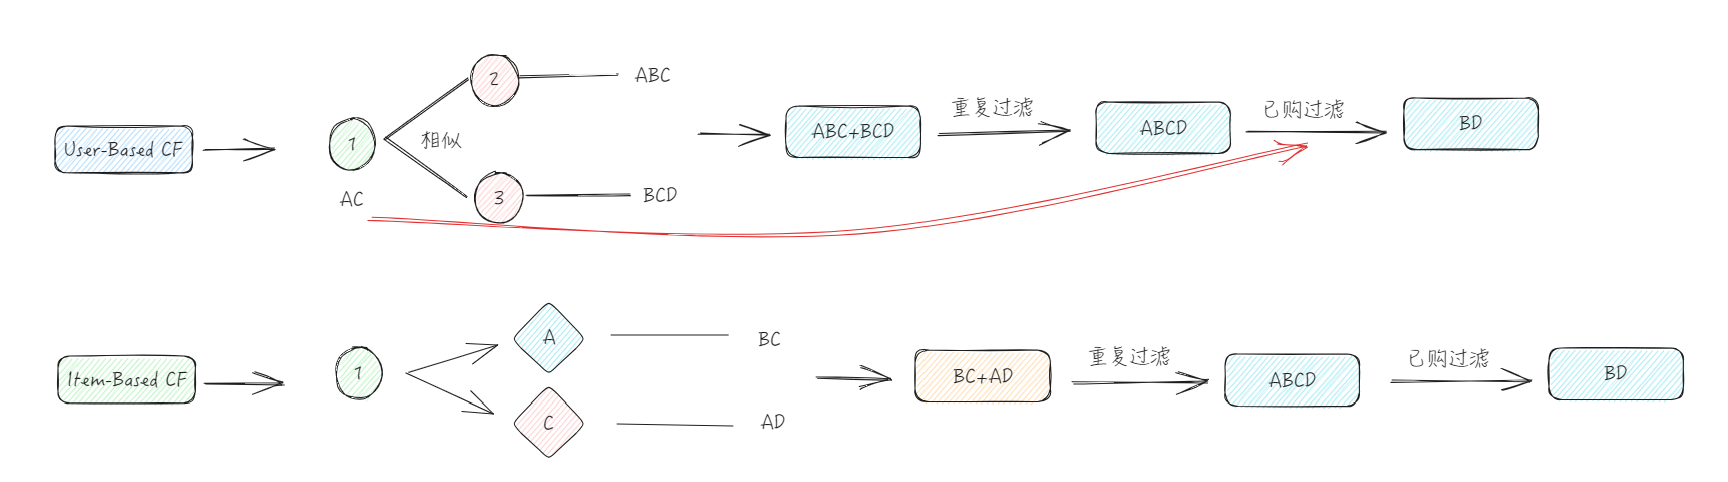

### itemcf i2i_sim
When calculating the `item2item` similarity matrix, association rules are applied to ensure that the similarity between articles also takes into account:

1. **Time Weight of User Clicks**  
   - The importance of when the user clicked on the article.

2. **Order Weight of User Clicks**  
   - The sequence in which the user clicked on the articles.

3. **Creation Time Weight of Articles**  
   - The significance of the article's creation time.

In [52]:
import pandas as pd
import os

# Get the current working directory
current_dir = os.getcwd()
file_path = os.path.join(current_dir, 'click_data.csv')

# Check if the file exists
if os.path.exists(file_path):
    try:
        all_click_df = pd.read_csv(file_path)
        print("Click data loaded successfully.")
    except Exception as e:
        print(f"An error occurred while loading the click data: {e}")
else:
    print(f"File not found: {file_path}. Please verify the file location.")


File not found: /content/click_data.csv. Please verify the file location.


In [54]:
def itemcf_sim(all_click_df, option='raw'):

    # Calculate item similarity
    # Use two nested loops to iterate over the list of articles clicked by each user
    # and compute the similarity between every pair of items.
    # For each pair of items i and j, calculate their similarity sim(i, j).
    # Common similarity measures include cosine similarity.

    user_item_time_dict = get_user_item_time(all_click_df)

    # Initialize dictionaries
    i2i_sim = defaultdict(dict)
    item_cnt = defaultdict(int)

    if option == 'raw':
        print('Raw similarity calculation\n')
        # Raw similarity accumulation process
        # Iterate over each user and their list of clicked items and times
        for user, item_time_list in tqdm(user_item_time_dict.items(),
                                         desc="Building item-item similarity matrix (raw)"):
            # Iterate over each item i clicked by the user
            for i, i_click_time in item_time_list:
                item_cnt[i] += 1  # Record the number of times item i was clicked

                # Nested iteration over each pair of items i and j clicked by the user
                for j, j_click_time in item_time_list:
                    if i == j:  # Skip if item i and item j are the same
                        continue

                    i2i_sim[i].setdefault(j, 0)  # Initialize similarity between i and j to 0 if not already set

                    # Accumulate similarity between item i and item j
                    i2i_sim[i][j] += 1 / math.log(len(item_time_list) + 1)

    elif option == 'weighted':
        print('Weighted similarity calculation\n')
        # Weighted similarity accumulation process
        for user, item_time_list in tqdm(user_item_time_dict.items(),
                                         desc="Building item-item similarity matrix (weighted)"):
            for loc1, (i, i_click_time) in enumerate(item_time_list):
                item_cnt[i] += 1
                i2i_sim.setdefault(i, {})
                for loc2, (j, j_click_time) in enumerate(item_time_list):
                    if i == j:
                        continue

                    # Consider both forward and backward sequential clicks
                    loc_alpha = 1.0 if loc2 > loc1 else 0.7
                    # Positional weight; parameters can be adjusted
                    loc_weight = loc_alpha * (0.9 ** (np.abs(loc2 - loc1) - 1))
                    # Click time weight; parameters can be adjusted
                    click_time_weight = np.exp(0.7 ** np.abs(i_click_time - j_click_time))
                    # Article creation time weight; parameters can be adjusted
                    created_time_weight = np.exp(0.8 ** np.abs(item_created_time_dict[i] - item_created_time_dict[j]))
                    i2i_sim[i].setdefault(j, 0)
                    # Calculate the final similarity between items considering multiple factors
                    i2i_sim[i][j] += (loc_weight * click_time_weight * created_time_weight /
                                      math.log(len(item_time_list) + 1))

    # Normalize the similarity values
    i2i_sim_final = defaultdict(dict)
    for i, related_items in i2i_sim.items():
        for j, wij in related_items.items():
            i2i_sim_final[i][j] = wij / math.sqrt(item_cnt[i] * item_cnt[j])

    # Save the similarity matrix to local storage
    with open(save_path + 'itemcf_i2i_sim.pkl', 'wb') as f:
        pickle.dump(i2i_sim_final, f)

    return i2i_sim_final


#### About Similarity Calculation

1. **Similarity Accumulation Process**:

   $$
   \text{sim}(i, j) = \sum_{u \in U_{ij}} \frac{1}{\log(1 + |N(u)|)}
   $$

   Where:
   - $ \text{sim}(i, j) $ represents the similarity between item $ i $ and item $ j $.
   - $ U_{ij} $ denotes the set of users who clicked both item $ i $ and item $ j $.
   - $ N(u) $ refers to the number of items clicked by user $ u $.

2. **Similarity Normalization Process**:

   $$
   \text{sim_normalized}(i, j) = \frac{\text{sim}(i, j)}{\sqrt{c(i) \times c(j)}}
   $$

   Where:
   - $ \text{sim_normalized}(i, j) $ denotes the normalized similarity between item $ i $ and item $ j $.
   - $ c(i) $ and $ c(j) $ represent the total number of clicks for item $ i $ and item $ j $, respectively.

> Why is `i2i_sim[i][j] += 1 / math.log(len(item_time_list) + 1)` calculated this way?

Similarity is calculated based on co-occurrence frequency. Here, `1 / log(len(item_time_list) + 1)` is used as the increment value for similarity to standardize across different lengths of user click lists.

- **Co-occurrence Frequency**: The similarity value reflects how often two items appear together in the same user’s click history. The more frequent the co-occurrence, the higher the similarity.
- **Normalization**: `1 / math.log(len(item_time_list) + 1)` normalizes the similarity increment to reduce the influence of long click lists on the calculation.

Assume the following user click data:

- **User A**: Clicked items 1, 2, and 3.
- **User B**: Clicked items 1 and 2.
- **User C**: Clicked items 2 and 3.

Steps to calculate similarity:

1. **Items 1 and 2**:
   - Both User A and User B clicked items 1 and 2, so the similarity between items 1 and 2 increases in the similarity matrix.
   - User A clicked items 1 and 2 (2 times), and User B also clicked them (1 time), so `i2i_sim[1][2]` increases by `1 / log(3)` (assuming User A's click list length is 3).

2. **Items 1 and 3**:
   - User A clicked items 1 and 3 (1 time), and User C clicked item 3 (1 time), so the similarity between items 1 and 3 increases by `1 / log(3)` (assuming User A's click list length is 3).

3. **Items 2 and 3**:
   - Both User A and User C clicked items 2 and 3, so the similarity between items 2 and 3 increases by `1 / log(3)` (assuming User A's click list length is 3).

- `loc_alpha = 1.0 if loc2 > loc1 else 0.7`: This line of code calculates the positional weight, considering the order in which the user clicked the articles. If article j was clicked after article i, `loc_alpha` is set to 1.0; otherwise, it is set to 0.7. This approach emphasizes that users are more likely to be interested in the most recently clicked articles rather than earlier ones.  
- `loc_weight = loc_alpha * (0.9 ** (np.abs(loc2 - loc1) - 1))`: This line calculates the weight based on positional information. The positional weight depends on the order of clicks between the articles, with larger distances resulting in smaller weights. The parameter 0.9 serves as the decay coefficient for the positional weight, reducing the impact of articles clicked further apart on similarity.  
- `click_time_weight = np.exp(0.7 ** np.abs(i_click_time - j_click_time))`: This line computes the weight based on click time. The click time weight accounts for the time interval between the user's clicks on the two articles. Shorter time intervals yield higher weights, indicating that the user is more likely to have a similar interest in both articles.  
- `created_time_weight = np.exp(0.8 ** np.abs(item_created_time_dict[i] - item_created_time_dict[j]))`: This line calculates the weight based on the creation time of the articles. The creation time weight considers the difference in the creation dates of the two articles. If the articles were created around the same time, the weight is higher; otherwise, it is lower.  
- `i2i_sim[i][j] += loc_weight * click_time_weight * created_time_weight / math.log(len(item_time_list) + 1)`: Finally, this line calculates the similarity between article i and article j, taking into account the positional information, click time, and creation time weights. The similarity is computed as a weighted sum using the aforementioned weights, and it is divided by a logarithmic term to balance the effect of frequent clicks.

In [ ]:
i2i_sim = itemcf_sim(all_click_df, option='weighted')

加权相似度计算



Building item-item similarity matrix (weighted): 100%|██████████| 1000/1000 [00:00<00:00, 1725.95it/s]


### usercf u2u_sim
When calculating the similarity between users, some simple association rules can also be applied, such as user activity weight. Here, the number of user clicks is used as an indicator of user activity.

In [ ]:
def get_user_activate_degree_dict(all_click_df):
    all_click_df_ = all_click_df.groupby('user_id')['click_article_id'].count().reset_index()

    # Normalize user activity
    mm = MinMaxScaler()
    all_click_df_['click_article_id'] = mm.fit_transform(all_click_df_[['click_article_id']])
    user_activate_degree_dict = dict(zip(all_click_df_['user_id'], all_click_df_['click_article_id']))

    # Here, user activity is measured by the number of articles clicked by the user.
    # After normalization, the activity level is represented by a value in the range [0, 1],
    # indicating the user's relative activity level.
    return user_activate_degree_dict


In [ ]:
def usercf_sim(all_click_df, user_activate_degree_dict):
    """
    User similarity matrix calculation.
    :param all_click_df: DataFrame
    :param user_activate_degree_dict: Dictionary of user activity levels
    :return: User similarity matrix
    """

    # Get a dictionary of users who clicked on each item.
    # Key is the item ID, value is the list of users who clicked the item.
    item_user_time_dict = get_item_user_time_dict(all_click_df)

    # Initialize the user similarity matrix
    u2u_sim = {}
    # Dictionary to count the number of items clicked by each user
    user_cnt = defaultdict(int)

    # Iterate over each item and its list of users who clicked it
    for item, user_time_list in tqdm(item_user_time_dict.items()):
        # Iterate over each user and their click time
        for u, click_time in user_time_list:
            # Count the number of items clicked by each user
            user_cnt[u] += 1
            # Initialize the user similarity matrix if it doesn't exist
            u2u_sim.setdefault(u, {})
            # Second iteration over users to calculate user similarity
            for v, click_time in user_time_list:
                # Initialize the similarity value for users if not already set
                u2u_sim[u].setdefault(v, 0)
                # Skip if the two users are the same (no self-similarity calculation)
                if u == v:
                    continue
                # Calculate the similarity weight considering user activity
                activate_weight = 100 * 0.5 * (user_activate_degree_dict[u] + user_activate_degree_dict[v])
                # user_activate_degree_dict[u] and user_activate_degree_dict[v] represent
                # the activity levels of users u and v (i.e., their normalized click counts).
                # Update the similarity value in the matrix for the two users
                u2u_sim[u][v] += activate_weight / math.log(len(user_time_list) + 1)

    # Copy the user similarity matrix to avoid modifying the original data
    u2u_sim_ = u2u_sim.copy()
    # Normalize the similarity values in the user similarity matrix
    for u, related_users in u2u_sim.items():
        for v, wij in related_users.items():
            u2u_sim_[u][v] = wij / math.sqrt(user_cnt[u] * user_cnt[v])

    # Save the user similarity matrix to the local storage
    pickle.dump(u2u_sim_, open(save_path + 'usercf_u2u_sim.pkl', 'wb'))

    return u2u_sim_


In [ ]:
user_activate_degree_dict = get_user_activate_degree_dict(all_click_df)
u2u_sim = usercf_sim(all_click_df, user_activate_degree_dict)

100%|██████████| 1780/1780 [00:00<00:00, 20437.73it/s]


### item embedding sim
Using embeddings to calculate the similarity between items is intended to facilitate retrieving articles that do not appear in the click data during cold start scenarios. A detailed introduction to the cold start process will be provided later, but here is a brief explanation of Faiss.

Faiss is an open-source software library developed by Facebook's AI team for clustering and similarity search, implemented in C++ at its core. Due to its outstanding performance, Faiss is widely used in recommendation-related services.

The Faiss toolkit is typically used in the vector recall stage of recommendation systems. In vector recall, the goal can be `u2u`, `u2i`, or `i2i`, where `u` refers to a user and `i` to an item. In real-world scenarios, the number of users and items is massive. A straightforward approach for vector similarity recall would involve using two nested loops to iterate through the user or item lists and calculate the similarity between pairs of vectors. However, this approach is impractical when dealing with large-scale data. Faiss is designed to accelerate the process of finding the top-k most similar vectors to a given query vector.

---

Faiss is an open-source software library developed by Facebook's AI research team for efficient similarity search and clustering of dense vectors. It is particularly useful in scenarios where large-scale similarity search is required, such as recommendation systems, image retrieval, and natural language processing tasks. Faiss is implemented in C++ with bindings available for Python and other languages.

The key feature of Faiss is its ability to perform approximate nearest neighbor search (ANN), which significantly speeds up the search process while maintaining high-quality results. Faiss achieves this by employing advanced algorithms and data structures optimized for high-dimensional vector spaces.

Example:
Let's consider a recommendation system scenario where we have a large number of user and item embeddings (dense vectors) representing users' preferences and items' features. The goal is to find the top-k most similar items to a given query item for personalized recommendations.


```python
import faiss

# Sample data: embeddings of items (item_vectors) and the query item (query_vector)
item_vectors = [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9], ...]
query_vector = [0.3, 0.4, 0.5]

# Convert the data to a numpy array
item_vectors = np.array(item_vectors, dtype=np.float32)
query_vector = np.array(query_vector, dtype=np.float32)

# Create an index for searching in Faiss (FlatL2 index, which uses L2 distance)
index = faiss.IndexFlatL2(item_vectors.shape[1])

# Add the item embeddings to the index
index.add(item_vectors)

# Perform the similarity search with the query vector
k = 5  # Number of nearest neighbors to retrieve
D, I = index.search(np.array([query_vector]), k)

# D: Distance of the query vector to the nearest neighbors (L2 distances)
# I: Indices of the k nearest neighbors in the item_vectors

# Print the results
print("Top 5 similar items to the query item:")
for i in I[0]:
    print(item_vectors[i])
```

**Principle of Faiss Query:**

1. **Index Structure Construction:**  
   In Faiss, the first step is to build an index structure for the vector dataset to be searched. Faiss provides various index structures, such as flat indexes, inverted file indexes (IVF), and product quantization indexes (PQ). Each index structure is suited to specific scenarios and requirements, allowing users to choose the most appropriate one based on their needs.

2. **Vector Encoding:**  
   Before constructing the index structure, vector data typically needs to be encoded. The purpose of encoding is to map high-dimensional vectors into a lower-dimensional space to reduce computation and storage costs. Common encoding methods include vector quantization and hash encoding.

3. **Query Process:**  
   Once the index structure is built, queries can be performed on it. The query process involves calculating the similarity between the query vector and the vectors stored in the index structure. Faiss provides multiple query methods, such as exact search and approximate search. In approximate search, Faiss uses algorithms such as Product Quantization (PQ) and Locality Sensitive Hashing (LSH) to accelerate the search process.

4. **Result Retrieval:**  
   After the query is complete, Faiss returns the indexes or distances of the top-k most similar vectors. Users can specify the number of results they need and process or analyze the returned results further.

---

1. **Product Quantization (PQ):**  
   - PQ divides a high-dimensional vector into multiple sub-vectors and independently quantizes each sub-vector. This maps the original high-dimensional vector into a lower-dimensional subspace, reducing computation and storage requirements.
   - The key to PQ lies in how the original vector is divided into sub-vectors and how appropriate quantization methods are designed. Common methods include Product Quantization and Residual Product Quantization.
   - PQ significantly reduces search time while maintaining search quality, making it especially useful for large-scale high-dimensional data in approximate nearest neighbor searches.

2. **Locality Sensitive Hashing (LSH):**  
   - LSH is a hash-based method for approximate nearest neighbor search. Its core idea is to map similar vectors into the same bucket so that similar vectors can be quickly located during the query.
   - LSH uses multiple hash functions to generate several hash values for each vector, which are then used to map the vectors into buckets. During a query, only the vectors in the query vector’s bucket and neighboring buckets are searched, eliminating the need to traverse the entire dataset.
   - LSH provides high search efficiency and scalability when dealing with large-scale data, particularly for high-dimensional data in approximate nearest neighbor searches.

---

Faiss utilizes two key techniques for vector compression and encoding: **PCA** (Principal Component Analysis) and **PQ** (Product Quantization), along with other optimization techniques. However, PCA and PQ are the core components.

1. **PCA for Dimensionality Reduction:**  
   For details on PCA, refer to the following link:  
   [Summary of Principal Component Analysis (PCA)](https://www.cnblogs.com/pinard/p/6239403.html)

2. **Product Quantization (PQ) Encoding:**  
   For more information on PQ, check out this link:  
   [Understanding Product Quantization with Examples](http://www.fabwrite.com/productquantization)

---

**Using Faiss:**

For the official Faiss tutorial, refer to:  
[Faiss Official Tutorial](https://github.com/facebookresearch/faiss/wiki/Getting-started)

### Calculate Similarity Matrix Based on Article Embeddings  

1. **Establish a Mapping Between Article Index and Article ID:**  
   - Create a mapping that links each article's index in the dataset to its corresponding article ID.

2. **Normalize Article Embedding Vectors:**  
   - Perform unit normalization on the embedding vectors of the articles to ensure that each vector has a unit norm. This step improves the performance and accuracy of similarity calculations.

3. **Build Faiss Index and Perform Similarity Query:**  
   - Construct a Faiss index using the normalized embedding vectors.  
   - Use the index to perform similarity searches and retrieve the top-k most similar articles for each query article.

4. **Save the Similarity Matrix:**  
   - Store the similarity matrix locally for future use in recommendation or retrieval tasks.

In [ ]:

import numpy as np
import faiss
import collections
import pickle
from tqdm import tqdm

def embdding_sim(click_df, item_emb_df, save_path, topk):
    """
    Content-based article embedding similarity matrix calculation.
    :param click_df: DataFrame containing click data.
    :param item_emb_df: DataFrame containing article embeddings.
    :param save_path: Path to save the similarity matrix.
    :param topk: Number of most similar articles to retrieve.
    :return: Article similarity matrix.

    Approach: For each article, return the top-k most similar articles based on embedding similarity.
    Since the number of articles is large, Faiss is used to accelerate the process.
    """

    # Dictionary mapping between article index and article ID
    item_idx_2_rawid_dict = dict(zip(item_emb_df.index, item_emb_df['article_id']))

    # Extract embedding columns
    item_emb_cols = [x for x in item_emb_df.columns if 'emb' in x]
    item_emb_np = np.ascontiguousarray(item_emb_df[item_emb_cols].values, dtype=np.float32)

    # Normalize the vectors
    item_emb_np = item_emb_np / np.linalg.norm(item_emb_np, axis=1, keepdims=True)

    # Build Faiss index
    item_index = faiss.IndexFlatIP(item_emb_np.shape[1])  # Inner Product index, embedding vector dimension as parameter
    item_index.add(item_emb_np)  # Add embeddings to the index

    # Perform similarity search for each article, returning top-k similar vectors
    sim, idx = item_index.search(item_emb_np, topk)

    # Dictionary to store similarity results with original article IDs
    item_sim_dict = collections.defaultdict(dict)

    # Add progress bar using tqdm
    for target_idx, sim_value_list, rele_idx_list in tqdm(zip(range(len(item_emb_np)), sim, idx), total=len(item_emb_np)):
        target_raw_id = item_idx_2_rawid_dict[target_idx]
        # Start from 1 to exclude the article itself, so the final result contains topk-1 similar articles
        for rele_idx, sim_value in zip(rele_idx_list[1:], sim_value_list[1:]):
            rele_raw_id = item_idx_2_rawid_dict[rele_idx]
            item_sim_dict[target_raw_id][rele_raw_id] = item_sim_dict.get(target_raw_id, {}).get(rele_raw_id, 0) + sim_value

    # Save the item-to-item similarity matrix as a pickle file
    pickle.dump(item_sim_dict, open(save_path + 'emb_i2i_sim.pkl', 'wb'))

    return item_sim_dict


In [ ]:
item_emb_df = pd.read_csv(data_path + '/articles_emb.csv')
# emb_i2i_sim = embdding_sim(all_click_df, item_emb_df, save_path, topk=10) # topk可以自行设置

### itemcf recall
Using the similarity matrices obtained through collaborative filtering and embedding-based retrieval, we can now implement a recall mechanism to recommend articles similar to the user’s previously clicked articles. In this recall process, we adopt the following association rule-based approach:

1. **Weight Based on the Order of Similar and Previously Clicked Articles:**  
   - The recall process assigns weights considering the order in which the user clicked the articles. (See the code for detailed implementation.)

2. **Weight Based on Article Creation Time:**  
   - We assign weights based on the difference in creation times between the similar articles and the previously clicked articles.

3. **Weight Based on Content Similarity of Articles:**  
   - We use embeddings to calculate the similarity between articles. However, it’s important to note that the embedding calculation does not compute the similarity between every pair of articles. Thus, if there is no existing similarity between a similar article and a previously clicked article, special handling is required.

In [ ]:

# Content-based recall for item-to-item (i2i)
def content_based_recommend(user_id, user_item_time_dict, i2i_sim, sim_item_topk, recall_item_num, item_topk_click, item_created_time_dict, emb_i2i_sim):
    """
    Recall based on article collaborative filtering.
    :param user_id: User ID
    :param user_item_time_dict: Dictionary to retrieve the user's clicked article sequence based on click time {user1: [(item1, time1), (item2, time2), ...]...}
    :param i2i_sim: Dictionary of article similarity matrix
    :param sim_item_topk: Integer, selecting the top k articles most similar to the current article
    :param recall_item_num: Integer, the final number of recalled articles
    :param item_topk_click: List, the list of articles with the most clicks for user recall completion
    :param emb_i2i_sim: Dictionary based on content embedding for article similarity matrix

    return: Recalled article list [(item1, score1), (item2, score2)...]
    """
    # Get the user's historical interacted articles
    user_hist_items = user_item_time_dict[user_id]
    user_hist_items_ = {user_id for user_id, _ in user_hist_items}

    item_rank = {}
    for loc, (i, click_time) in enumerate(user_hist_items):
        for j, wij in sorted(i2i_sim[i].items(), key=lambda x: x[1], reverse=True)[:sim_item_topk]:
            if j in user_hist_items_:
                continue

            # Weight based on the difference in creation times
            created_time_weight = np.exp(0.8 ** np.abs(item_created_time_dict[i] - item_created_time_dict[j]))
            # Weight based on the position of the historical article in the user's clicked sequence
            loc_weight = (0.9 ** (len(user_hist_items) - loc))

            content_weight = 1.0
            if emb_i2i_sim.get(i, {}).get(j, None) is not None:
                content_weight += emb_i2i_sim[i][j]
            if emb_i2i_sim.get(j, {}).get(i, None) is not None:
                content_weight += emb_i2i_sim[j][i]

            item_rank.setdefault(j, 0)
            item_rank[j] += created_time_weight * loc_weight * content_weight * wij

    # Fill up with popular items if fewer than 10
    if len(item_rank) < recall_item_num:
        for i, item in enumerate(item_topk_click):
            if item in item_rank:  # Items to fill should not be in the original list
                continue
            item_rank[item] = -i - 100  # Assign any negative value
            if len(item_rank) == recall_item_num:
                break

    item_rank = sorted(item_rank.items(), key=lambda x: x[1], reverse=True)[:recall_item_num]

    return item_rank


```python
content_weight = 1.0
if emb_i2i_sim.get(i, {}).get(j, None) is not None:
    content_weight += emb_i2i_sim[i][j]
if emb_i2i_sim.get(j, {}).get(i, None) is not None:
    content_weight += emb_i2i_sim[j][i]

```
The `emb_i2i_sim` here is the article similarity matrix calculated based on content embeddings. Since the similarity between all article pairs was not computed during the embedding calculation, the `content_weight` is initially set to 1.0 when considering the content similarity weight between article i and article j.

Then, we check whether the similarity between article i and article j exists in `emb_i2i_sim`, as well as whether the similarity from article j to article i exists. If either exists, the corresponding similarity value is added to `content_weight`.

In this way, when there is no directly computed similarity between the two articles, `content_weight` remains at 1.0. If there is an indirect similarity relationship (i.e., either article i has similarity to article j or article j has similarity to article i), the value of `content_weight` will be increased accordingly. This effectively compensates for the lack of direct computation of similarities between all article pairs, allowing for special handling of the situation.

#### itemcf sim recall

In [ ]:
# First, perform item-based collaborative filtering (itemCF) recall. To evaluate the recall, extract the last click.

if metric_recall:
    trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)
else:
    trn_hist_click_df = all_click_df

user_recall_items_dict = collections.defaultdict(dict)
user_item_time_dict = get_user_item_time(trn_hist_click_df)

i2i_sim = pickle.load(open(save_path + 'itemcf_i2i_sim.pkl', 'rb'))
emb_i2i_sim = pickle.load(open(save_path + 'emb_i2i_sim.pkl', 'rb'))

sim_item_topk = 20
recall_item_num = 10
item_topk_click = get_item_topk_click(trn_hist_click_df, k=50)

np.random.seed(42)  # set random seed
for user in tqdm(trn_hist_click_df['user_id'].sample(500).unique()):
    user_recall_items_dict[user] = content_based_recommend(user, user_item_time_dict, \
                                                        i2i_sim, sim_item_topk, recall_item_num, \
                                                        item_topk_click, item_created_time_dict, emb_i2i_sim)

user_multi_recall_dict['itemcf_sim_itemcf_recall'] = user_recall_items_dict
pickle.dump(user_multi_recall_dict['itemcf_sim_itemcf_recall'], open(save_path + 'itemcf_recall_dict.pkl', 'wb'))

if metric_recall:
    # 召回效果评估
    metrics_recall(user_multi_recall_dict['itemcf_sim_itemcf_recall'], trn_last_click_df, topk=recall_item_num)

100%|██████████| 362/362 [00:00<00:00, 966.47it/s]


#### embedding sim recall

In [ ]:

# This is for recall evaluation, so the last click is extracted
if metric_recall:
    trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)
else:
    trn_hist_click_df = all_click_df

user_recall_items_dict = collections.defaultdict(dict)
user_item_time_dict = get_user_item_time(trn_hist_click_df)
i2i_sim = pickle.load(open(save_path + 'emb_i2i_sim.pkl', 'rb'))

sim_item_topk = 20
recall_item_num = 10

item_topk_click = get_item_topk_click(trn_hist_click_df, k=50)

np.random.seed(42)  # Set random seed
for user in tqdm(trn_hist_click_df['user_id'].sample(500).unique()):
    user_recall_items_dict[user] = content_based_recommend(user, user_item_time_dict, i2i_sim, sim_item_topk,
                                                            recall_item_num, item_topk_click, item_created_time_dict, emb_i2i_sim)

user_multi_recall_dict['embedding_sim_item_recall'] = user_recall_items_dict
pickle.dump(user_multi_recall_dict['embedding_sim_item_recall'], open(save_path + 'embedding_sim_item_recall.pkl', 'wb'))

if metric_recall:
    # Recall performance evaluation
    metrics_recall(user_multi_recall_dict['embedding_sim_item_recall'], trn_last_click_df, topk=recall_item_num)


100%|██████████| 362/362 [00:00<00:00, 1905.33it/s]


### UserCF Recall

Based on user collaborative filtering, the core idea is to recommend articles that are similar to the historical clicks of users with similar profiles. Since this involves the historical articles of similar users, we can still apply some association rules to weight the articles that the user might click. The association rules used here primarily consider the relationship weights between the historical clicked articles of similar users and the articles clicked by the recommended user. This relationship can directly borrow from the methods used in item-based collaborative filtering, but it involves an accumulation process of the relationships for the recommended items. Below are some of the relationship weights used and the relevant code:

1. Calculate the similarity between the historical clicked articles of the recommended user and those of similar users, taking into account the differences in article creation times and the total relative positions, which serve as respective weights.

In [ ]:
# 基于用户的召回 u2u2i
def user_based_recommend(user_id, user_item_time_dict, u2u_sim, sim_user_topk, recall_item_num,
                         item_topk_click, item_created_time_dict, emb_i2i_sim):
    """
        基于文章协同过滤的召回
        :param user_id: 用户id
        :param user_item_time_dict: 字典, 根据点击时间获取用户的点击文章序列   {user1: [(item1, time1), (item2, time2)..]...}
        :param u2u_sim: 字典，文章相似性矩阵
        :param sim_user_topk: 整数， 选择与当前用户最相似的前k个用户
        :param recall_item_num: 整数， 最后的召回文章数量
        :param item_topk_click: 列表，点击次数最多的文章列表，用户召回补全
        :param item_created_time_dict: 文章创建时间列表
        :param emb_i2i_sim: 字典基于内容embedding算的文章相似矩阵

        return: 召回的文章列表 [(item1, score1), (item2, score2)...]
    """
    # 历史交互
    user_item_time_list = user_item_time_dict[user_id]    #  [(item1, time1), (item2, time2)..]
    user_hist_items = set([i for i, t in user_item_time_list])   # 存在一个用户与某篇文章的多次交互， 这里得去重

    items_rank = {}
    for sim_u, wuv in sorted(u2u_sim[user_id].items(), key=lambda x: x[1], reverse=True)[:sim_user_topk]:
        for i, click_time in user_item_time_dict[sim_u]:
            if i in user_hist_items:
                continue
            items_rank.setdefault(i, 0)

            loc_weight = 1.0
            content_weight = 1.0
            created_time_weight = 1.0

            # 当前文章与该用户看的历史文章进行一个权重交互
            for loc, (j, click_time) in enumerate(user_item_time_list):
                # 点击时的相对位置权重
                loc_weight += 0.9 ** (len(user_item_time_list) - loc)
                # 内容相似性权重
                if emb_i2i_sim.get(i, {}).get(j, None) is not None:
                    content_weight += emb_i2i_sim[i][j]
                if emb_i2i_sim.get(j, {}).get(i, None) is not None:
                    content_weight += emb_i2i_sim[j][i]

                # 创建时间差权重
                created_time_weight += np.exp(0.8 * np.abs(item_created_time_dict[i] - item_created_time_dict[j]))

            items_rank[i] += loc_weight * content_weight * created_time_weight * wuv

    # 热度补全
    if len(items_rank) < recall_item_num:
        for i, item in enumerate(item_topk_click):
            if item in items_rank.items(): # 填充的item应该不在原来的列表中
                continue
            items_rank[item] = - i - 100 # 随便给个复数就行
            if len(items_rank) == recall_item_num:
                break

    items_rank = sorted(items_rank.items(), key=lambda x: x[1], reverse=True)[:recall_item_num]

    return items_rank

#### usercf sim recall

In [ ]:

# User-based recall u2u2i
def user_based_recommend(user_id, user_item_time_dict, u2u_sim, sim_user_topk, recall_item_num,
                         item_topk_click, item_created_time_dict, emb_i2i_sim):
    """
    Recall based on article collaborative filtering.
    :param user_id: User ID
    :param user_item_time_dict: Dictionary to retrieve the user's clicked article sequence based on click time {user1: [(item1, time1), (item2, time2), ...]...}
    :param u2u_sim: Dictionary of user similarity matrix
    :param sim_user_topk: Integer, selecting the top k users most similar to the current user
    :param recall_item_num: Integer, the final number of recalled articles
    :param item_topk_click: List, the list of articles with the most clicks for user recall completion
    :param item_created_time_dict: List of article creation times
    :param emb_i2i_sim: Dictionary based on content embedding for article similarity matrix

    return: Recalled article list [(item1, score1), (item2, score2)...]
    """
    # Historical interactions
    user_item_time_list = user_item_time_dict[user_id]  # [(item1, time1), (item2, time2), ...]
    user_hist_items = set([i for i, t in user_item_time_list])  # Remove duplicates as a user may interact with the same article multiple times

    items_rank = {}
    for sim_u, wuv in sorted(u2u_sim[user_id].items(), key=lambda x: x[1], reverse=True)[:sim_user_topk]:
        for i, click_time in user_item_time_dict[sim_u]:
            if i in user_hist_items:
                continue
            items_rank.setdefault(i, 0)

            loc_weight = 1.0
            content_weight = 1.0
            created_time_weight = 1.0

            # Interact weights between the current article and the historical articles viewed by this user
            for loc, (j, click_time) in enumerate(user_item_time_list):
                # Relative position weight during clicks
                loc_weight += 0.9 ** (len(user_item_time_list) - loc)
                # Content similarity weight
                if emb_i2i_sim.get(i, {}).get(j, None) is not None:
                    content_weight += emb_i2i_sim[i][j]
                if emb_i2i_sim.get(j, {}).get(i, None) is not None:
                    content_weight += emb_i2i_sim[j][i]

                # Creation time difference weight
                created_time_weight += np.exp(0.8 * np.abs(item_created_time_dict[i] - item_created_time_dict[j]))

            items_rank[i] += loc_weight * content_weight * created_time_weight * wuv

    # Hot item completion
    if len(items_rank) < recall_item_num:
        for i, item in enumerate(item_topk_click):
            if item in items_rank:  # Items to fill should not be in the original list
                continue
            items_rank[item] = -i - 100  # Assign any negative value
            if len(items_rank) == recall_item_num:
                break

    items_rank = sorted(items_rank.items(), key=lambda x: x[1], reverse=True)[:recall_item_num]

    return items_rank

100%|██████████| 362/362 [00:04<00:00, 80.62it/s]


##  Cold Start Problem

**The cold start problem can be divided into three categories: article cold start, user cold start, and system cold start.**

- **Article Cold Start:** This refers to the challenge of recommending newly added articles to a platform that have no interaction records. (In our context, articles that have not appeared in the log data can be considered cold start articles.)

- **User Cold Start:** This pertains to a new user on the platform who has no interaction information regarding articles. The challenge is how to recommend articles to this user. (In our context, we can determine if a user in the test set has appeared in the corresponding log data. If they have not, they can be considered a cold start user. However, this criterion can be flexible; we might define certain metrics to identify cold start users, such as usage duration, click-through rates, retention rates, etc.)

- **System Cold Start:** This occurs when a platform has just launched and has no relevant historical data. It is essentially a combination of the previous two types.

---

**Analysis of the Cold Start Problem in the Current Context:**

Analyzing the current data reveals that there are only about 30,000 articles clicked in the logs, while the entire article database contains over 300,000 articles. This raises the question: will users in the test set click on articles that do not appear in the logs? If such cases exist, it indicates that the articles clicked by users previously lack any interaction information, representing what we call article cold start. Further analysis shows that a significant proportion of users in the test set have only one click recorded. Recommending articles based solely on a single click from the user is challenging. This also highlights the user cold start issue, but we will focus on providing solutions and code for the article cold start while suggesting feasible approaches for user cold start.

1. **Article Cold Start (Exploration of Non-cold Start Articles):**  
   Our goal is not to specifically address the cold start of articles, but rather to predict which articles users might click that have not appeared in the log data. We need to determine how to select a subset of articles from nearly 270,000 options as potential cold start articles. This can be viewed as a recall strategy, and we will adopt a simple rule-based recall strategy to identify articles that users may click but that have not been logged.

   The question now becomes: how do we select a small portion of articles for each user from 270,000 options? Random selection might be one approach. Below are some suggested strategies:
   - **Embedding-based Recall:** Retrieve a subset of articles similar to the user's historical clicks by utilizing the article embedding vectors to find articles that are close to the user's clicked articles in vector space.
   - **Rule Filtering:** Apply rules to filter the articles recalled based on embeddings. For example, retain articles with similar themes to the user’s historical clicks and similar word counts; select articles whose creation dates are closer to the last click time of the test set user or articles created on that day. This approach can enhance the likelihood of recalled articles being clicked by users.

2. **User Cold Start:**  
   Analysis of the click data for users in the test set shows that about 20% of users have only one click recorded. Can we implement specific strategies for these users with very few clicks? Alternatively, could we enhance the recommendations by adding some articles based on rules after sorting?

In [ ]:

# First, perform itemCF recall. There is no need for recall evaluation here; this is merely a strategy.
trn_hist_click_df = all_click_df

user_recall_items_dict = collections.defaultdict(dict)
user_item_time_dict = get_user_item_time(trn_hist_click_df)
i2i_sim = pickle.load(open(save_path + 'emb_i2i_sim.pkl', 'rb'))

sim_item_topk = 150
recall_item_num = 100  # Recall a slightly larger number of articles for subsequent rule filtering

np.random.seed(42)  # Set random seed
item_topk_click = get_item_topk_click(trn_hist_click_df, k=50)
for user in tqdm(trn_hist_click_df['user_id'].sample(500).unique()):
    user_recall_items_dict[user] = content_based_recommend(user, user_item_time_dict, i2i_sim, sim_item_topk,
                                                            recall_item_num, item_topk_click, item_created_time_dict, emb_i2i_sim)
pickle.dump(user_recall_items_dict, open(save_path + 'cold_start_items_raw_dict.pkl', 'wb'))


100%|██████████| 362/362 [00:00<00:00, 839.15it/s]


In [ ]:
# Article filtering based on rules
# Retain articles with similar themes to the user's historical browsing topics
# Retain articles with a word count similar to the user's historical clicked articles
# Retain articles created on the same day as the last click
# Return the final results sorted by similarity

def get_click_article_ids_set(all_click_df):
    return set(all_click_df.click_article_id.values)

def cold_start_items(user_recall_items_dict, user_hist_item_typs_dict, user_hist_item_words_dict, \
                     user_last_item_created_time_dict, item_type_dict, item_words_dict,
                     item_created_time_dict, click_article_ids_set, recall_item_num):
    """
    Recall articles in the case of cold start.
    :param user_recall_items_dict: Many articles recalled based on content embedding similarity,
                                    dictionary format: {user1: [(item1, item2), ..], }
    :param user_hist_item_typs_dict: Dictionary mapping the themes of articles clicked by users
    :param user_hist_item_words_dict: Dictionary mapping the word counts of users' historical articles
    :param user_last_item_created_time_dict: Dictionary mapping the creation times of users' historical articles
    :param item_type_dict: Dictionary mapping article themes
    :param item_words_dict: Dictionary mapping article word counts
    :param item_created_time_dict: Dictionary mapping article creation times
    :param click_article_ids_set: Set of articles that the user has clicked, i.e., articles that have appeared in the logs
    :param recall_item_num: The number of articles to recall, referring to the number of articles that have not appeared in the logs
    """

    cold_start_user_items_dict = {}
    for user, item_list in tqdm(user_recall_items_dict.items()):
        cold_start_user_items_dict.setdefault(user, [])
        for item, score in item_list:
            # Get historical article information
            hist_item_type_set = user_hist_item_typs_dict[user]
            hist_mean_words = user_hist_item_words_dict[user]
            hist_last_item_created_time = user_last_item_created_time_dict[user]
            hist_last_item_created_time = datetime.fromtimestamp(hist_last_item_created_time)

            # Get current recalled article information
            curr_item_type = item_type_dict[item]
            curr_item_words = item_words_dict[item]
            curr_item_created_time = item_created_time_dict[item]
            curr_item_created_time = datetime.fromtimestamp(curr_item_created_time)

            # First, the article must not appear in the user's historical clicks. Then filter based on article theme, word count, and creation time.
            if curr_item_type not in hist_item_type_set or \
                item in click_article_ids_set or \
                abs(curr_item_words - hist_mean_words) > 200 or \
                abs((curr_item_created_time - hist_last_item_created_time).days) > 90:
                continue

            cold_start_user_items_dict[user].append((item, score))  # {user1: [(item1, score1), (item2, score2)..]...}

    # Control the number of recalled cold start items
    cold_start_u


The main objective is to recall articles that users may be interested in based on their historical browsing records and the features of the articles in cold start scenarios. The specific logic is as follows:

1. Traverse the list of articles recalled based on embeddings. For each article, retrieve the relevant information about the user's historical clicked articles (theme set, average word count, last click time) and the current recalled article's information (theme, word count, creation time).

2. Apply a series of filtering rules:

   - The article must not appear in the user's historical clicks to ensure the novelty of the recommendations.
   - The article's theme should be present in the user's historical clicked article theme set to ensure thematic similarity.
   - The word count of the article must not differ from the user's historical clicked articles' average word count by more than 200, ensuring similar content length.
   - The creation time of the article should not differ from the creation time of the user's last clicked article by more than 90 days to ensure that the recommended articles are relatively recent.

3. If the article passes these filtering criteria, it is added to the user's cold start recommendation list.

4. Finally, sort each user's cold start recommendation list by the scores of the articles and retain the top `recall_item_num` articles to ensure that the number of recommendations meets the requirements. The processed cold start recommendation results are saved as a pickle file.

In [ ]:
all_click_df_ = all_click_df.copy()
all_click_df_ = all_click_df_.merge(item_info_df, how='left', on='click_article_id')
user_hist_item_typs_dict, user_hist_item_ids_dict, user_hist_item_words_dict, user_last_item_created_time_dict = get_user_hist_item_info_dict(all_click_df_)
click_article_ids_set = get_click_article_ids_set(all_click_df)

# It is important to note that
# Many rules are used to filter cold start articles, so in the previous recall stage,
# it is necessary to recall as many articles as possible; otherwise, they are likely to be filtered out.
cold_start_user_items_dict = cold_start_items(user_recall_items_dict, user_hist_item_typs_dict, user_hist_item_words_dict, \
                                              user_last_item_created_time_dict, item_type_dict, item_words_dict, \
                                              item_created_time_dict, click_article_ids_set, recall_item_num)

user_multi_recall_dict['cold_start_recall'] = cold_start_user_items_dict


100%|██████████| 362/362 [00:00<00:00, 2257.18it/s]


## Multi-route Recall Merging

Multi-route recall merging involves combining the user article lists obtained from all the previous recall strategies. Below is a summary of all the recall results:

1. Recall based on the similarity `sim` between items calculated using item-based collaborative filtering (itemCF).
2. Recall based on the similarity between items obtained through embedding searches.
3. Recall based on cold start strategies.

In [ ]:
def combine_recall_results(user_multi_recall_dict, weight_dict=None, topk=25):
    final_recall_items_dict = {}

    # Normalize the recall results for each method by user, allowing for the weights of items to be summed across different recall results for the same user
    def norm_user_recall_items_sim(sorted_item_list):
        # If there are no articles in the cold start or only one article, return directly. This situation may occur if the number of articles recalled in the cold start is too low,
        # resulting in no articles after rule filtering. Other strategic filtering can also be implemented here.
        if len(sorted_item_list) < 2:
            return sorted_item_list

        min_sim = sorted_item_list[-1][1]
        max_sim = sorted_item_list[0][1]

        norm_sorted_item_list = []
        for item, score in sorted_item_list:
            if max_sim > 0:
                norm_score = 1.0 * (score - min_sim) / (max_sim - min_sim) if max_sim > min_sim else 1.0
            else:
                norm_score = 0.0
            norm_sorted_item_list.append((item, norm_score))

        return norm_sorted_item_list

    print('Merging multi-route recall results...')
    for method, user_recall_items in tqdm(user_multi_recall_dict.items()):
        print(method + '...')
        # Optionally set a weight for each recall method when calculating the final recall results
        if weight_dict is None:
            recall_method_weight = 1
        else:
            recall_method_weight = weight_dict[method]

        for user_id, sorted_item_list in user_recall_items.items():  # Normalize the results
            user_recall_items[user_id] = norm_user_recall_items_sim(sorted_item_list)

        for user_id, sorted_item_list in user_recall_items.items():
            final_recall_items_dict.setdefault(user_id, {})
            for item, score in sorted_item_list:
                final_recall_items_dict[user_id].setdefault(item, 0)
                final_recall_items_dict[user_id][item] += recall_method_weight * score

    final_recall_items_dict_rank = {}
    # Control the final recall quantity during multi-route recall
    for user, recall_item_dict in final_recall_items_dict.items():
        final_recall_items_dict_rank[user] = sorted(recall_item_dict.items(), key=lambda x: x[1], reverse=True)[:topk]

    # Save the final results dictionary from multi-route recall to local storage
    pickle.dump(final_recall_items_dict_rank, open(os.path.join(save_path, 'final_recall_items_dict.pkl'), 'wb'))

    return final_recall_items_dict_rank


In [ ]:
# Here, a uniform value is assigned to the weights of the multi-route recall, but it can actually be adjusted based on the results of the previous recalls.
weight_dict = {'itemcf_sim_itemcf_recall': 1.0,
               'embedding_sim_item_recall': 1.0,
               'cold_start_recall': 1.0}

In [ ]:
# After merging, each user will have 5 recalled items sorted.
final_recall_items_dict_rank = combine_recall_results(user_multi_recall_dict, weight_dict, topk=150)

多路召回合并...


100%|██████████| 3/3 [00:00<00:00, 49.83it/s]

itemcf_sim_itemcf_recall...
embedding_sim_item_recall...
cold_start_recall...


In [ ]:
multi_recall_score_list = []

for user, items in tqdm(final_recall_items_dict_rank.items()):
    if isinstance(items, (list, tuple)):  # To ensure that items is iterable in Python
        for item, score in items:
            multi_recall_score_list.append([user, item, score])
    else:
        print(f"Error: items for user {user} is not iterable")

recall_df = pd.DataFrame(multi_recall_score_list, columns=['user_id', 'click_article_id', 'pred_score'])


100%|██████████| 362/362 [00:00<00:00, 637.11it/s]


In [ ]:
def submit(recall_df, topk=5, model_name=None):
    # Sort the DataFrame by 'user_id' and 'pred_score' columns
    recall_df = recall_df.sort_values(by=['user_id', 'pred_score'])

    # Add a 'rank' column indicating each user's prediction ranking
    recall_df['rank'] = recall_df.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')

    # Check if each user has at least 'topk' articles
    tmp = recall_df.groupby('user_id').apply(lambda x: x['rank'].max())
    assert tmp.min() >= topk

    # Delete the 'pred_score' column
    del recall_df['pred_score']

    # Select the top 'topk' predictions for each user and reshape the DataFrame
    submit = recall_df[recall_df['rank'] <= topk].set_index(['user_id', 'rank']).unstack(-1).reset_index()

    # Rename columns according to the submission format
    submit.columns = [int(col) if isinstance(col, int) else col for col in submit.columns.droplevel(0)]
    submit = submit.rename(columns={'': 'user_id', 1: 'article_1', 2: 'article_2',
                                    3: 'article_3', 4: 'article_4', 5: 'article_5'})

    # Generate the filename for saving the CSV file
    save_name = save_path + model_name + '_' + datetime.today().strftime('%m-%d') + '.csv'

    # Save the DataFrame as a CSV file, without the index, and include header information
    submit.to_csv(save_name, index=False, header=True)

    return submit


In [ ]:
recall_df['click_article_id'] = recall_df['click_article_id'].astype(int)
submit(recall_df, topk=5, model_name='multiple_recall')

,user_id,article_1,article_2,article_3,article_4,article_5
0,804,244851,245077,245004,244936,243557
1,1139,30955,28747,245195,22024,245702
2,1630,206960,353849,203386,158772,149690
3,2228,289197,332517,332188,331070,328867
4,2871,332517,331583,332188,331070,328867
...,...,...,...,...,...,...
357,197976,286008,284464,285196,282249,279593
358,197980,30752,332517,31655,331583,30739
359,198115,284603,59069,237621,42223,235297
360,198372,161446,107196,162338,160132,160450
